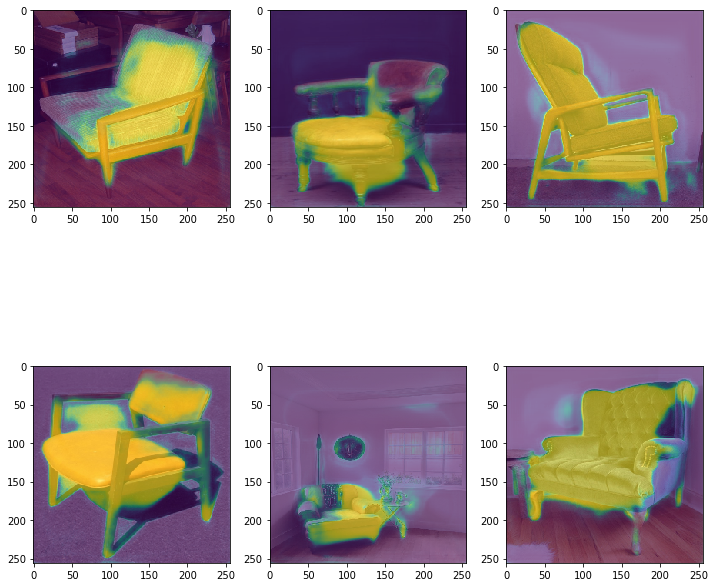

### Problem Statement:
Given a single piece of furniture in context, can you automatically seperte the furniture from the background?

#### Solution:
This problem is called segmentation, Essentailly we want to go from this:
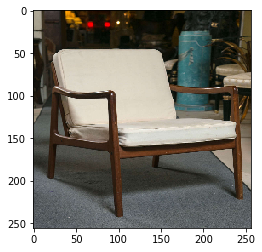

to this:
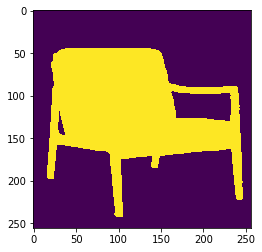

- We can apply this mask to the source image to get just the chair without the background

We're going to use a few tools to make our lives easier:
1. keras
    - an awesome library for building neural networks
    - keras is a front-end to lower level libraries like Tensorflow that handles a lot of the messy details of building neural networks for you
    - we won't actually need to use keras directly in this guide, but if you peek under the hood Keras is what you'll see
2. U-Net
    - neural network architecture for image segmentation
    - was originally designed for biomedical image segmentation
    - eg.
        - identifying lung nodules in a CT scan
    - but it also works for segmenting regular 2D images
    - U-Net works surprisingly well even when you don't have a large dataset
3. brine
    - dataset manager to make it easy to share and manipulate image datasets
    - one of the most annoying parts of building a model is getting and wrangling the datasets we need to train our models.
    - brine was created to easily share datasets and use them with PyTorch/Keras models
    - We'll be using it to download the dataset and interface it with Keras so we won't have to do any crufty data format wrangling ourselves
4. this github repo
    - The Carvana Image Masking Challenge was a Kaggle competetion posing a similar problem.
    - **Problem Statement** - segmenting out cars from their background.
    - People often share their solutions to Kaggle competetions and in this repo, someone has helpfully shared a clean solution that uses Keras and U-Net.
    - Our goal is going to be to repurpose this solution to solve the furniture segmentation problem.
5. this dataset
    - This is a dataset provided by a friend of the author's who posed this problem to him.
    - It's a small dataset, containing only 97 images of chairs and the corresponding masks.
    - Normally the author would'nt expect to be able to do much with such limited data(the Carvana challenge provided thousands of examples) but let's see how far we can get with it.

### Code
- jupyter notebook for the entire code is available [here](https://github.com/brine-io/u-net-segmentation-example/blob/master/U-Net%20Furniture%20Segmentation%20Example.ipynb)
- Important parts and explanation of what it's doing:
    1. First step is to install the dataset
        - Since it's hosted on brine we can do this h a simple ```brine install rohan/chairs-with-masks```
    2. Next step is to load the dataset
        - We do this via the Brine ```load_dataset``` function
        - ```chairs = brine.load_dataset('rohan/chairs-with-masks')```
        - This dataset contains 97 samples with each sample being a pair of the image and its mask
        - The mask is a 2 color image where blue represents the background and red represents the foreground.
    3. Load up the U-Net network
        - ***Copy over the ```model``` directory from the Kaggle-Carvana-Image-Masking-Challenge github repo so we have it available to us.***
        - After importing it, we can do ```model=unet.get_unet_256()```
        - Thanks to ***[petrosgk's work](https://github.com/petrosgk)*** that single function calls return a U-Net network built in Keras.
        - Keras gives us ```model.summary()``` method that we can use to see the structure of the network.
        - The ***most important lines to look at** are the ***first and the last***.
        - These tell us the shapes of the inputs and the outputs the network expects.
        - We can see that the input shape is ***(None, 256, 256, 3)*** and the output shape is ***(None, 256, 256, 3)***.
        - The first element of the tuple is referring to the mini-batch size, so we can ignore it for now.
        - This tells us the networks expects a batch of 256x256x3 channel images as input and will output a batch of 256x256 single channel masks.
        - Ours masks need to match this shape as well
        - Our next step then is to prepare our samples so they can be used with this network
        - We'll define a processing function for our training data which will be applied to each sample before the sample is passed to the network during the training.

<code>
def fix_mask(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0
    
def train_process(sample):
    img, mask = sample
    img = img[:, :, :3]
    mask = mask[:, :, :3]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    img = randomHueSaturationValue(img,
                                    hue_shift_limit=(-50, 50),
                                    sat_shift_limit=(0, 0),
                                    val_shift_limit=(-15, 15))
    img, mask = randomSiftScaleRotate(img,
                                        mask,
                                        shift_limit=(-0.062, 0.062),
                                        scale_limit=(-0.1, 0.1),
                                        rotate_limit=(-20, 20))
    img, mask = randomHorizontalFlip(img, mask)
    fix_mask(mask)
    img = img/255.0
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)
    
</code>

#### Explanation of the above code
- We've passed in the sample as a tuple so we first unpack it
- The next 2 lines use numpy slicing to ensure that we only have 3 channel images, if there is a 4th channel we ignore it
- Next we convert the mask to grayscale using cv2(python bindings to OpenCV)
- We now have a single channel mask as our network expects
- Instead of using 2 random grayscale numbers for the 2 colors, we force the mask to 0 and 255 to denote the background and foreground using the fix_mask function
- We the resize both the images and the mask to 256x256 to match the size expected by the network
- Since we don't have a lot of data, we're going to use ***data augmentation***.
- Data augmentation refers to randomly modifying the image at training time in ways that preserve the information in order to artificially generate more data
- For example, a chair rotated by 5 degrees is still a chair, so the network should be able to identify that correctly.
- In our code we using 3 functions from ***petrosgk's*** Carvana example to randomly alter the hue, saturation and value of the image and to randomly rotate and flip the image.
- If we rotate or flip the image, we have to perform the same operation on the mask so that the mask stays aligned with the original image.
- First we normalize the data by dividing all the pixel values by 255, so our values are all between 0 and 1.
- If you were to print ```image.shape``` at this point you'd see that it's ```256x256x3``` exactly what our network needs.
- However ```mask.shape``` is ```256x256``` wheares the network requires ```256x256x1``` so we use ```np.expand_dims()``` to make the mask match this shape.
- Finally we return the new image and mask pair
- Before we start training the network, we also need to set some of the samples aside to be used for validation
- Finally we return the new image and the mask pair
- Before we start training the network we also need to set some of the samples aside to be used for validation.
- The validation fold won't be used for training we'll only us the validation fold to check the performance of the model
- We can easily create the folds using Brine's ```create_folds```
    <code>validation_fold, train_fold = chairs.create_folds((20, ))</code>
- We've asked for 20 samples in the validation fold, and the remaining 77 samples will be assigned to the training fold.
- We also define a processing function we use for training, except at validation time we won't unnecessarily make the network's job harder by using data augmentation

- Finally we ask Brine to return a generator we can use with Keras for both the train and validation folds:
<code>
train_generator = train_fold.to_keras(
    'image',
    'mask',
    batch_size=BATCH_SIZE,
    shuffle=True, 
    processing_function=train_process)
validation_generator = validation_fold.to_keras(
    'image',
    'mask',
    batch_size=BATCH_SIZE,
    shuffle=False,
    processing_function=validation_process)
</code>

- This gives us the generators that returns the batches of samples processing with the processing functins we defined earlier
- These generators can be passed directly into Keras' fit_generator method to train our model
- Now we're ready to train the model
- We'll use the callbacks from ***petrosgk*** as well for our training
```
callbacks = [EarlyStopping(monitor='val_loss',
                            patience=8,
                            verbose=1,
                            min_delta=1e-4),
                ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.1,
                                    patience=4,
                                    verbose=1,
                                    epsilon=1e-4),
                ModelCheckpoint(monitor='val_loss',
                                filepath='weights/best_weights.hdf5',
                                save_best_only=True,
                                save_weights_only=True)]
```
- These callbacks modify Keras training loop.
- EarlyStopping will stop training once it stops seeing improvement to the validation loss, ReduceLROnPlateau will drop the learning rate and ModelCheckpoint will save the version of the model that performs best on our validation set.

- Finally, we can start training
```
epochs=100
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    epoch=epochs,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.steps_per_epoch())
```
- Keras will train the model running through the dataset multiple times(though each run will be slightly different because of data augmentation and shuffling) and will output our losses and DICE scores for our train and validation set.
- At some point, we'll stop either because of our EarlyStopping callback or because we hit 100 epochs
- That's it! We've now trained a U-Net network that tries to segment chairs out of an image. Let's see how well it does in practise.

#### Generating predictions
- To generate predictions we'll first load the weights of the best model using ```model.load_weights('weights/best_weights.hdf5')```.
- We'll then use our model's ```predict``` method on some of the images in our validation set.
<code>
def predict_one():
    image_batch, mask_batch = next(validation_generator)
    predicted_mask_batch = model.predict(image_batch)
    image = image_batch[0]
    predicted_mask = predicted_mask_batch[0].reshape(SIZE)
    plt.imshow(image)
    plt.imshow(predicted_mask, alpha=0.6)
</code>

#### Here's a sampling of some of the results:
- 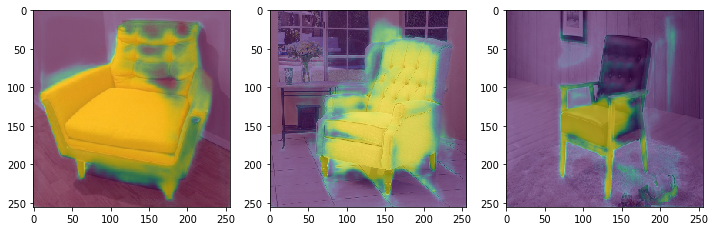
- While this isn't good enough for a production use-case yet, the network has learned something about foreground vs background and chair vs non-chair.
- The author finds it quite amazing given that the network was trained on only 77 images without any pre training.
- Given a larger dataset, it's possible that the network migh get to an accuracy that allows this to be used for a production use case, or atleast for a first pass that can be further refined by a human.

In [1]:
%matplotlib inline
import brine
import cv2
import numpy as np
from model.augmentations import randomHueSaturationValue, randomShiftScaleRotate, randomHorizontalFlip
import model.u_net as unet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
import glob
import PIL
import joblib
import h5py as h5py

/home/vishal/workspace/python3.6_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_image_labels(folder, border_sz=1):
    image = glob.glob(folder + '/images/*')[0]
    image = cv2.imread(image)[:, :, ::-1]
    masks = glob.glob(folder + '/masks/*')
    all_masks = []
    for i, mask in enumerate(masks):
        mask_img = np.sum(cv2.imread(mask), axis=-1)
        mask_img = cv2.erode(mask_img.astype(np.uint8),np.ones((3, 3), np.uint8),iterations = 1)
        all_masks.append((mask_img.astype(np.int16) * (i + 1)))
    if len(masks) == 0:
        return image
    return image, np.sum(all_masks, axis=0, dtype=np.int16)

def convert_masks(masks, border_sz=2):
    return np.sum(
        [extract_border(mask, border_sz) for mask in masks],
        axis=0
    )

In [3]:
def load_train_data():
    x = []
    x_pixels = []
    y = []
    y_pixels = []
    for path in glob.glob('../data/stage1_train/*/'):
        image, mask = load_image_labels(path)
        x_pixels.append(image)
        x.append(PIL.Image.fromarray(image))
        y_pixels.append(mask)
        y.append(PIL.Image.fromarray(mask))
    return (x, y), (x_pixels, y_pixels)

#load_train_data.clear()

(FULL_TRAIN_X, FULL_TRAIN_Y), (FULL_TRAIN_X_pixels, FULL_TRAIN_Y_pixels)\
            = load_train_data()

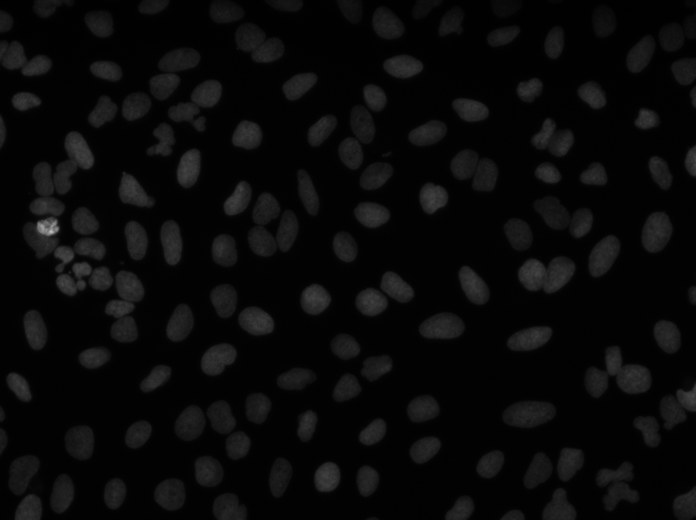

In [4]:
FULL_TRAIN_X[0]

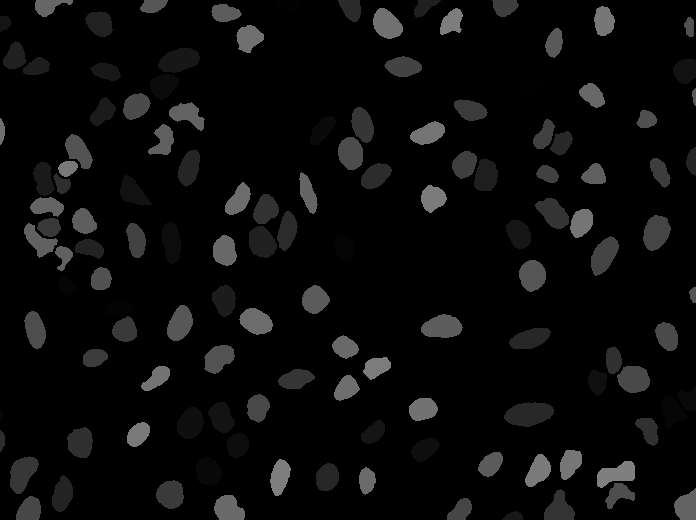

In [5]:
FULL_TRAIN_Y[0]

In [6]:
print(FULL_TRAIN_X_pixels[0])
print(FULL_TRAIN_X_pixels[0].shape)

[[[ 1  1  1]
  [ 1  1  1]
  [ 1  1  1]
  ...
  [ 8  8  8]
  [ 7  7  7]
  [ 8  8  8]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 1  1  1]
  ...
  [ 7  7  7]
  [ 8  8  8]
  [ 7  7  7]]

 [[ 1  1  1]
  [ 2  2  2]
  [ 1  1  1]
  ...
  [ 8  8  8]
  [ 9  9  9]
  [ 9  9  9]]

 ...

 [[ 1  1  1]
  [ 1  1  1]
  [ 1  1  1]
  ...
  [10 10 10]
  [ 9  9  9]
  [11 11 11]]

 [[ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]
  ...
  [ 7  7  7]
  [ 5  5  5]
  [ 6  6  6]]

 [[ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]
  ...
  [ 5  5  5]
  [ 4  4  4]
  [ 4  4  4]]]
(520, 696, 3)


In [7]:
print(FULL_TRAIN_Y_pixels[0])
print(FULL_TRAIN_Y_pixels[0].shape)

[[    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [    0     0     0 ... 25553 25553 25553]
 [    0     0     0 ... 25553 25553 25553]
 [    0     0     0 ... 25553 25553 25553]]
(520, 696)


#### processing function for our train data

In [8]:
def fix_mask(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0
    
def train_process(sample):
    size = (256, 256)
    img, mask = sample
    img = img[:,:,:3]
#     mask = mask[:, :, :3]
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, size)
    mask = cv2.resize(mask, size)
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-50, 50),
                                   sat_shift_limit=(0, 0),
                                   val_shift_limit=(-15, 15))
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.062, 0.062),
                                       scale_limit=(-0.1, 0.1),
                                       rotate_limit=(-20, 20))
    img, mask = randomHorizontalFlip(img, mask)
    fix_mask(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

In [9]:
FULL_TRAIN_X_pixels_mod = []
FULL_TRAIN_Y_pixels_mod = []
for image, mask in zip(FULL_TRAIN_X_pixels, FULL_TRAIN_Y_pixels): 
    img, mask = train_process((image, mask))
    FULL_TRAIN_X_pixels_mod.append(img)
    FULL_TRAIN_Y_pixels_mod.append(mask)
print(FULL_TRAIN_X_pixels_mod[0], FULL_TRAIN_Y_pixels_mod[0])

[[[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.02745098 0.02745098 0.02745098]
  [0.02745098 0.02745098 0.02745098]
  [0.02745098 0.02745098 0.02745098]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03529412 0.03529412 0.03529412]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]
  [0.03137255 0.03137255 0.03137255]]

 ...

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.09411765 0.09411765 0.09411765]
  [0.09803922 0.09803922 0.09803922]
  [0.10196078 0.10196078 0.10196078]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00784314 0.00784314 0.00784314]


In [10]:
def train_generator(batch_size=1, shuffle=False):
    obj = list(zip(X_train, y_train))
    if shuffle == True:
        np.random.shuffle(obj)
    counter = 0
#     while (counter + batch_size) < len(obj):
    if counter + batch_size >= len(obj):
        counter = len(obj) - 1 - batch_size
    img, mask = zip(*obj[counter:counter+batch_size])
    counter = (counter + batch_size) % len(obj)
    while True:
        yield np.array(img), np.array(mask)

In [11]:
def validation_generator(batch_size=1, shuffle=False):
    obj = list(zip(X_validation, y_validation))
    if shuffle == True:
        np.random.shuffle(obj)
    counter = 0
    if counter + batch_size >= len(obj):
        counter = len(obj) - 1 - batch_size
#     while (counter + batch_size) < len(obj):
    img, mask = zip(*obj[counter:counter+batch_size])
    counter = (counter + batch_size) % len(obj)
    while True:
        yield np.array(img), np.array(mask)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_validation, y_train, y_validation = \
        train_test_split(FULL_TRAIN_X_pixels_mod,\
                         FULL_TRAIN_Y_pixels_mod,\
                         train_size = 0.6)

/home/vishal/workspace/python3.6_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

In [17]:
import model.u_net as unet

In [18]:
model = unet.get_unet_256(num_classes=1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
len(X_validation)

268

In [20]:
epochs = 100
a = train_generator()
b = validation_generator()
model.fit_generator(generator=a,\
                    steps_per_epoch=1000,\
                    epochs=10,\
                    callbacks=callbacks,\
                    validation_data=b,\
                    validation_steps=len(X_validation)
                    )

Epoch 1/10
1000/1000 [==============================] - 595s 595ms/step - loss: 0.0966 - dice_coeff: 0.9402 - val_loss: 8.8332 - val_dice_coeff: 0.0455
Epoch 2/10
1000/1000 [==============================] - 294s 294ms/step - loss: 0.0084 - dice_coeff: 0.9946 - val_loss: 14.1462 - val_dice_coeff: 0.0498
Epoch 3/10
1000/1000 [==============================] - 158s 158ms/step - loss: 7.0964e-04 - dice_coeff: 0.9996 - val_loss: 15.4018 - val_dice_coeff: 0.0452
Epoch 4/10
1000/1000 [==============================] - 159s 159ms/step - loss: 2.8404e-05 - dice_coeff: 1.0000 - val_loss: 15.6947 - val_dice_coeff: 0.0434
Epoch 5/10
1000/1000 [==============================] - 158s 158ms/step - loss: 1.0345e-06 - dice_coeff: 1.0000 - val_loss: 15.7389 - val_dice_coeff: 0.0424
Epoch 6/10
 999/1000 [============================>.] - ETA: 0s - loss: 1.0579e-07 - dice_coeff: 1.0000
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1000/1000 [=============================

#### Using the model to make predictions

model.load_weights('weights/best_weights.hdf5')

In [21]:
def predict_one():
    image_batch, mask_batch = next(b)
    predicted_mask_batch = model.predict(image_batch)
    image = image_batch[0]
    predicted_mask = predicted_mask_batch[0].reshape(256, 256)
#     plt.imshow(image)
#     plt.imshow(predicted_mask, alpha=0.6)
    return image, predicted_mask

In [22]:
image, predict_mask = predict_one()

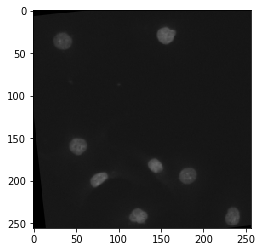

In [23]:
plt.imshow(image)

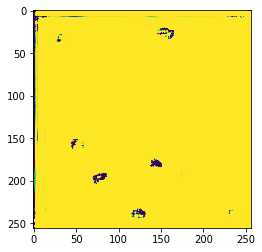

In [24]:
plt.imshow(predict_mask)